In [1]:
# -*- coding: utf-8 -*-
import collections
import math
import os
import numpy as np
import random
from six.moves import xrange
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
if tf.__version__[0] == '2':
    # Using TensorFlow 1.x to train our word2vec
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
%matplotlib inline  

In [2]:
folder_dir  = ""
filename   = "tag_list.txt"
vocabulary_size = 990

In [3]:
batch_size     = 128
embedding_size = 64       # Dimension of the embedding vector.
skip_window    = 1         # How many words to consider left and right.
num_skips      = 2         # How many times to reuse an input 

In [4]:
# Random validation set to sample nearest neighbors.
valid_size     = 32        # Random set of words to evaluate similarity 
valid_window   = 200       # Only pick validation samples in the top 200
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [5]:
file_path   = os.path.join(folder_dir, filename)
with open(file_path, 'r', encoding="utf-8") as f:
    words = f.read().split()

In [6]:
words

['sea',
 'instapic',
 'instagram',
 'trip',
 'travel',
 'sea',
 'sea',
 'love',
 'beach',
 'sea',
 'trip',
 'island',
 'japan',
 'sun',
 'sand',
 'sea',
 'sky',
 'friend',
 'beach',
 'thailand',
 'trip',
 'adventure',
 'vsco',
 'vscocam',
 'blue',
 'bluesky',
 'sea',
 'nature',
 'naturelovers',
 'church',
 'road',
 'nikon',
 'photograph',
 'sea',
 'beach',
 'beach',
 'sea',
 'spring',
 'wild',
 'top',
 'sunday',
 'ocean',
 'sea',
 'portrait',
 'mylove',
 'beach',
 'wave',
 'sun',
 'happy',
 'holiday',
 'love',
 'nature',
 'sea',
 'beach',
 'germany',
 'home',
 'travel',
 'joy',
 'nofilter',
 'water',
 'amazing',
 'pictureoftheday',
 'beach',
 'sea',
 'crazy',
 'brasil',
 'surf',
 'surfing',
 'indonesia',
 'nature',
 'beach',
 'awesome',
 'sea',
 'traveler',
 'adventure',
 'sea',
 'beach',
 'vacation',
 'holiday',
 'look',
 'place',
 'moment',
 'sand',
 'tagsforlikes',
 'dance',
 'sweet',
 'sea',
 'photooftheday',
 'sunset',
 'sea',
 'sun',
 'italy',
 'light',
 'sky',
 'sunday',
 'frien

In [7]:
word_count = [['UNK', -1]] 
word_count.extend(collections.Counter(words)
             .most_common(vocabulary_size - 1)) # -1 is for UNK 
print ("%s" % (word_count[0:10]))

[['UNK', -1], ('love', 5892), ('friend', 3646), ('beach', 3025), ('family', 2966), ('yellow', 2667), ('girl', 2614), ('fashion', 2371), ('nike', 2253), ('snow', 2212)]


In [8]:
# Create word -> wordID dictionary
dictionary = dict() 
for word, _ in word_count:
    dictionary[word] = len(dictionary)

# Create reverse dictionary (wordID -> word)
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [9]:
# Convert word into wordID, and count unused words (UNK)
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)
word_count[0][1] = unk_count
# del words  # Hint to reduce memory.

In [10]:
print ("Most common words (+UNK) are: %s" % (word_count[:10]))

Most common words (+UNK) are: [['UNK', 37], ('love', 5892), ('friend', 3646), ('beach', 3025), ('family', 2966), ('yellow', 2667), ('girl', 2614), ('fashion', 2371), ('nike', 2253), ('snow', 2212)]


In [11]:
print ("Sample data corresponds to\n__________________")
for i in range(10):
    print ("%d->%s" % (data[i], reverse_dictionary[data[i]]))

Sample data corresponds to
__________________
33->sea
90->instapic
60->instagram
145->trip
64->travel
33->sea
33->sea
1->love
3->beach
33->sea


In [12]:
# Data batch generator
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch  = np.ndarray(shape=(batch_size),    dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips): # '//' makes the result an integer, e.g., 7//3 = 2
        target = skip_window
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [13]:
# Construct the word2vec model 
train_inputs   = tf.placeholder(tf.int32, shape=[batch_size])   
train_labels   = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset  = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs. (vocabulary_size = 50,000)
with tf.variable_scope("EMBEDDING"):
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
# Construct the variables for the NCE loss
with tf.variable_scope("NCE_WEIGHT"):
    nce_weights = tf.Variable(
                        tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [14]:
with tf.device('/cpu:0'):
    # Loss function 
    num_sampled = 64        # Number of negative examples to sample. 
    
    loss = tf.reduce_mean(
                 tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocabulary_size))

    # Optimizer
    optm = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # Similarity measure (important)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    siml = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
print(normalized_embeddings.shape)

(990, 64)


In [16]:
# Train! 
sess = tf.Session()
sess.run(tf.initialize_all_variables())
#summary_writer = tf.summary.FileWriter('./w2v_train', graph=sess.graph)
average_loss = 0

num_steps = 40001
for iter in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
    _, loss_val = sess.run([optm, loss], feed_dict=feed_dict)
    average_loss += loss_val
    
    if iter % 2000 == 0:
        average_loss /= 2000
        print ("Average loss at step %d is %.3f" % (iter, average_loss)) 
    
    if iter % 10000 == 0:
        siml_val = sess.run(siml)
        for i in xrange(valid_size): # Among valid set 
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 6 # number of nearest neighbors
            nearest = (-siml_val[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to '%s':" % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]] 
                log_str = "%s '%s'," % (log_str, close_word)
            print(log_str) 
            
# Final embeding 
final_embeddings = sess.run(normalized_embeddings)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Average loss at step 0 is 0.073
Nearest to 'sunset': 'for', 'time', 'beer', 'freedom', 'denim', 'cosmetic',
Nearest to 'april': 'drink', 'organic', 'foto', 'depression', 'italiangirl', 'hungry',
Nearest to 'daily': 'together', 'gettingready', 'ocean', 'goodfriends', 'clothes', 'scenery',
Nearest to 'vsco': 'asia', 'sleepy', 'success', 'redlips', 'squat', 'you',
Nearest to 'snow': 'nightlife', 'mcm', 'fashionblog', 'rose', 'tulip', 'instamoment',
Nearest to 'art': 'picstitch', 'king', 'make', 'grunge', 'pant', 'nba',
Nearest to 'love': 'justinbieber', 'kuwait', 'saturday', 'fitfam', 'jean', 'comment',
Nearest to 'photooftheday': 'goingout', 'birthdaycake', 'mambaday', 'motd', 'polishgirl', 'candle',
Nearest to 'instamood': 'besties', 'girlswithtattoos', 'hollywood', 'dad', 'relax', 'france',
Nearest to 'lunch': 'live', 'dessert', 'follower', 'ootd', 'retro', 'iphoneonly',
Nearest to 'nike': 'song', 'dubai', 'dark'

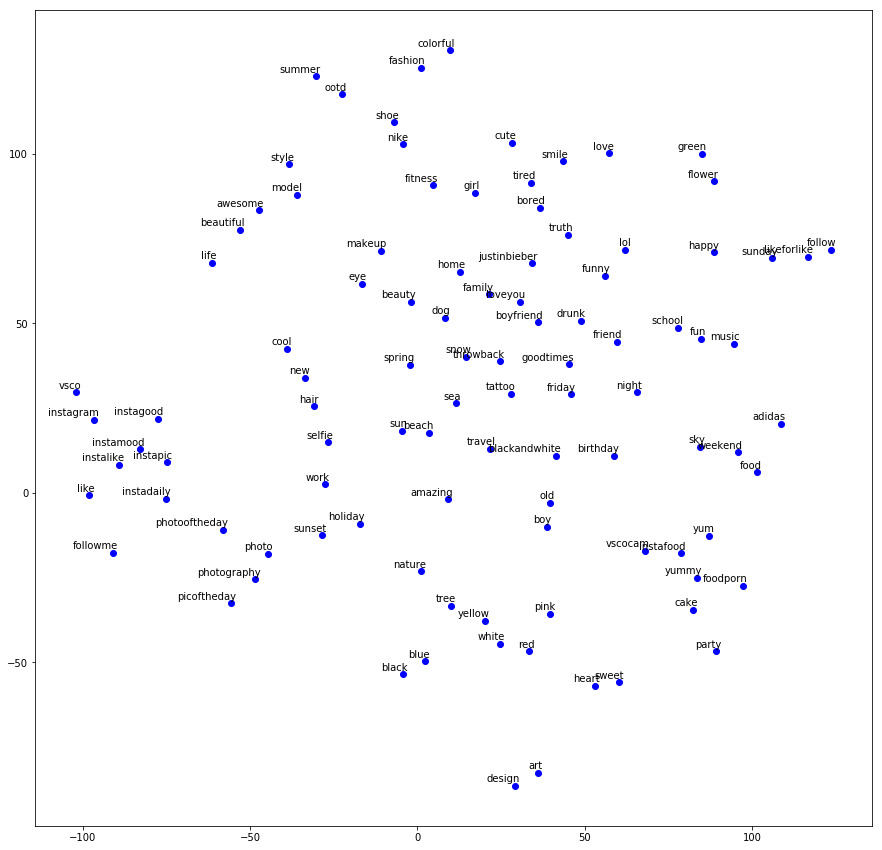

In [17]:
num_points = 100
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y, color=['blue'])
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [18]:
# Save only Numpy matrices to 'word2vec.npz'
np.savez(filename[0:-4] +'_word2vec_' + str(embedding_size), word_count=word_count, dictionary=dictionary, reverse_dictionary=reverse_dictionary, word_embeddings=final_embeddings)

In [19]:
# Test numpy word2vectors
K = 10
target = 'drunk'
scores = final_embeddings[dictionary[target]].dot(final_embeddings.transpose())
scores = scores / np.linalg.norm(final_embeddings, axis=1)
k_neighbors = (-scores).argsort()[0:K+1]  

print('The nearest neighbors of', target, 'are:')
for k in k_neighbors:
    print(reverse_dictionary[k], ' ', scores[k])

The nearest neighbors of drunk are:
drunk   0.99999994
throwback   0.61235434
goodtimes   0.58692616
loveyou   0.55288154
boyfriend   0.53002864
friend   0.51943254
funny   0.5137056
mine   0.5114776
forever   0.50466436
bar   0.49620253
bored   0.49314025


In [21]:
# (Optional) You can download the embedding vectors and upload to projector.tensorflow.org
out_v = open('vecs.tsv', 'w', encoding='utf-8')
out_m = open('meta.tsv', 'w', encoding='utf-8')
for num, word in enumerate(dictionary):
  vec = final_embeddings[num] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

from IPython.display import FileLink
FileLink('vecs.tsv')

C:\Users\廖勗宏\projectjupyter\HWtest\DL\105820024_DLHW2\vecs.tsv

In [22]:
from IPython.display import FileLink
FileLink('meta.tsv')

C:\Users\廖勗宏\projectjupyter\HWtest\DL\105820024_DLHW2\meta.tsv

In [23]:
# Download your word embedding vectors
from IPython.display import FileLink
FileLink(filename[0:-4] +'_word2vec_' + str(embedding_size) + '.npz')

C:\Users\廖勗宏\projectjupyter\HWtest\DL\105820024_DLHW2\tag_list_word2vec_64.npz